# U-Net 
Version of the scientific paper:   
O. Ronneberger and P.Fischer and T. Brox, 2015, U-Net: Convolutional Networks for Biomedical Image Segmentation, Medical Image Computing and Computer-Assisted Intervention (MICCAI). 

**Our goal is to segment the food elements in each image from Tray Dataset.**  

In [1]:
import torch
import torch.nn as nn
import torchmetrics as met
import torchvision.transforms.functional as functional

import pickle as pkl
import numpy as np

## Data

The data need a layout:
- need to reshape to 572x572
- need to create a Dataset class

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [3]:
#Preparing the Dataset class
class TrayDataset(Dataset):

    def __init__(self, annotations_file_path, 
                 _img_dir_path, _label_dir_path,
                 _transforms = None, _target_transforms = None):
        super(TrayDataset, self).__init__()

        self.labels            = pd.read_csv(annotations_file_path)
        self.img_dir_path      = _img_dir_path
        self.label_dir_path    = _label_dir_path
        self.transforms        = _transforms
        self.target_transforms = _target_transforms


    #Must be the nof samples
    def __len__(self):
        return len(os.listdir(self.img_dir_path))


    def __getitem__(self, img_idx):

        #/!\ NOT THAT GOOD BECAUSE DATA LIST ARE SORTED EVERY TIME WE ACCESS#
        img_name   = sorted(os.listdir(self.img_dir_path))[img_idx]
        label_name = sorted(os.listdir(self.label_dir_path))[img_idx]

        #Get the image
        image_path = self.img_dir_path + img_name
        image      = Image.open(image_path)
        if self.transforms:
            image  = self.transforms(image)
        #Get the label
        label_path = self.label_dir_path + label_name
        label      = Image.open(label_path)
        if self.target_transforms:
            label  = self.target_transforms(label)

        return image, label


In [4]:
# Class to transform Masks (targets) into a Tensor without the unwanted scaling
class MaskPILToTensor:

    def __call__(self, img):
        img = functional.pil_to_tensor(img)
        return img

## Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Conv_x2(nn.Module):

    def __init__(self, in_ch, out_ch, ker_size=3):

        super(Conv_x2, self).__init__()

        self.conv_x2 = nn.Sequential (
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ker_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=ker_size),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv_x2(x)


class Block_down_unet(nn.Module):

    def __init__(self, in_ch, out_ch, ker_size=3):

        super(Block_down_unet, self).__init__()

        self.block = nn.Sequential (
            nn.MaxPool2d(kernel_size=2, stride=2),
            Conv_x2(in_ch, out_ch, 3)
        )

    def forward(self, x):
        return self.block(x)



class Block_up_unet(nn.Module):

    def __init__(self, in_ch, out_ch, ker_size=3):

        super(Block_up_unet, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels=in_ch, out_channels=(in_ch//2), kernel_size=2, stride=2)
        self.conv_x2 = Conv_x2(in_ch, out_ch)

    def forward(self, concat_tensor, processed_tensor):
        
        #Upsampling
        processed_tensor = self.up(processed_tensor)

        #Padding and concatenation path
        diffY = concat_tensor.size()[2] - processed_tensor.size()[2]
        diffX = concat_tensor.size()[3] - processed_tensor.size()[3]

        x = F.pad(processed_tensor, [diffX // 2, diffX - diffX // 2,
                                     diffY // 2, diffY - diffY // 2])

        x = torch.cat([concat_tensor, x], dim=1)

        #Double convolution
        x = self.conv_x2(x)

        return x


class UNet(nn.Module):

    def __init__(self, in_channels, n_classes):

        super(UNet, self).__init__()

        self.nof_channels = in_channels
        self.nof_classes  = n_classes

        #First layer
        self.first_layer = Conv_x2(self.nof_channels, 64)

        #Contracting path
        self.down1 = Block_down_unet(64, 128, 3)
        self.down2 = Block_down_unet(128, 256, 3)
        self.down3 = Block_down_unet(256, 512, 3)

        #Bottom layer
        self.down4 = Block_down_unet(512, 1024, 3)

        #Expanding path
        self.up1 = Block_up_unet(1024, 512, 3)
        self.up2 = Block_up_unet(512, 256, 3)
        self.up3 = Block_up_unet(256, 128, 3)
        self.up4 = Block_up_unet(128, 64, 3)

        #Last block with 1x1 convolution
        self.last_block = nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=1)


    def forward(self, X):

        #Encoder (contracting path)
        x1 = self.first_layer(X)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        #Bottom layer
        x5 = self.down4(x4)

        #Decode (expanding path + concatenating path)
        x = self.up1(x4, x5)
        x = self.up2(x3, x)
        x = self.up3(x2, x)
        x = self.up4(x1, x)

        #Last layer (unomalized logits (sum != 1 and can be negatives))
        logits = self.last_block(x)

        return logits


## Trainer

In [7]:
class Trainer:

    def __init__(self, model, train_dataset, test_dataset, optimizer, loss_fn, metric_fn, device):
        
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.optimizer = optimizer
        self.criterion = loss_fn
        
        self.device = device
        
        if next(model.parameters()).device != self.device:
            self.model = model.to(self.device)
        else:
            self.model = model

        if metric_fn.device != self.device:
            self.metric = metric_fn.to(self.device)

    def get_train_dataloader(self, **kwargs) -> DataLoader:

        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
        else:
            _batch_size = 32
            
        if 'shuffle' in kwargs:
            _shuffle = kwargs.get('shuffle')
        else:
            _shuffle = True

        return DataLoader(self.train_dataset, shuffle=_shuffle, batch_size=_batch_size)


    def get_test_dataloader(self, **kwargs) -> DataLoader:

        if self.train_dataset is None:
            raise ValueError("Trainer: testing requires a test_dataset.")

        if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
        else:
            _batch_size = 32
        if 'shuffle' in kwargs:
            _shuffle = kwargs.get('shuffle')
        else:
            _shuffle = True

        return DataLoader(self.test_dataset, shuffle=_shuffle, batch_size=_batch_size)


    def train_step(self, train_loader):

        running_loss = 0.0
        self.model.train()

        for data in train_loader:

                #Data send to device + requires_grad=True
                images, targets = data[0].to(self.device), data[1].to(self.device)
                #Zero the gradient
                self.optimizer.zero_grad()
                #Predictions 
                outputs = self.model(images)
                #Cropping (crop imgs --> easier to process)
                crop_image = transforms.CenterCrop(outputs.size()[3])
                targets    = crop_image(targets)
                #Loss
                _, targets = torch.max(targets, dim=1)
                loss = self.criterion(outputs, targets)
                #Compute gradient
                loss.backward()
                #Update parameters of the model
                self.optimizer.step()
                
                running_loss += loss.item()

        return running_loss / len(train_loader)


    def test_step(self, test_loader):

        running_loss   = 0.0
        accuracy        = 0.0
        nof_predictions = 0.0

        self.model.eval()

        #Fasten the inference by setting every requires_grad to False
        with torch.no_grad():

            for data in test_loader:
                #Get data and send them to the device
                images, targets = data[0].to(self.device), data[1].to(self.device) 
                #Run the model on the test set
                outputs = self.model(images)
                #Cropping the image /!\ /!\ MUST GO /!\ /!\
                crop_image = transforms.CenterCrop(outputs.size()[3])
                targets     = crop_image(targets)
                #Compute the loss on the batch
                _, targets = torch.max(targets, dim=1)
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()  
                # Compute the Jaccard Multiclass index
                _, target = torch.max(targets, dim=0)
                self.metric.update(outputs, targets)

        accuracy = self.metric.compute()

        return accuracy


    def train(self, train_loader, test_loader, nof_epochs, 
              file_path_save_model, save_epoch_path, results_file_path,
              train_loss_name, accuracy_name, test_loss_name,
              best_accuracy_is_maximal = False):
        """
            Main training entry point.
        """
        print("Starting training...\n")
        print("The model will be running on", next(self.model.parameters()).device, "device.\n")
        
        best_accuracy = 0.0
        results = []

        for epoch in range(1, nof_epochs+1):

            epoch_accuracy   = 0.0
            train_epoch_loss = 0.0
            test_epoch_loss  = 0.0

            #Training
            train_epoch_loss = self.train_step(train_loader)
            #Validation
            epoch_accuracy   = self.test_step(test_loader)
        
            print(f'Epoch: {epoch}, {train_loss_name}: {train_epoch_loss}, {accuracy_name}: {epoch_accuracy}')
            
            #Save model when best accuracy is beaten
            if best_accuracy_is_maximal:
                if epoch_accuracy > best_accuracy:
                    save_epoch_path = save_epoch_path
                    self.save_model(save_epoch_path)
                    best_accuracy = epoch_accuracy
            else:
                if epoch_accuracy < best_accuracy:
                    save_epoch_path = save_epoch_path
                    self.save_model(save_epoch_path)
                    best_accuracy = epoch_accuracy

            results.append((epoch, train_epoch_loss, epoch_accuracy))        

        # Saving the model
        print('Saving the model...\n')
        self.model = self.model.to('cpu')
        self.save_model(file_path_save_model)

        # Saving the performances
        with open(results_file_path, 'wb') as f:
            pkl.dump(results, f) 

        print("Training finish.\n") 

        return self.model


    def save_model(self, file_path):
        """
        Function to save model's parameters
        """
        torch.save(self.model.state_dict(), file_path)


    def load_model(self, file_path, load_on_GPU=True):
        """
            Function to load function when only the params have been saved
        """
        if load_on_GPU:
            params = torch.load(file_path, map_location='cuda:0')
            self.model.load_state_dict(params, map_location='cuda:0')
        else:
            params = torch.load(file_path, map_location='cpu')
            self.model.load_state_dict(params, map_location='cpu')


    def save_checkpoint(self, epoch, file_path):
        """
            Function to save model's checkpoints
        """
        torch.save({'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': self.loss}, 
                    file_path)


    def load_checkpoint(self, file_path, load_on_GPU=True):
        """
            Load checkpoints
        """
        if load_on_GPU:
            checkpoint = torch.load(file_path, map_location='cuda:0')
        else:
            checkpoint = torch.load(file_path, map_location='cpu')

        #Loading
        if load_on_GPU:
            self.model.load_state_dict(checkpoint['model_state_dict'], map_location='cuda:0')
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location='cuda:0')
        else:
            self.model.load_state_dict(checkpoint['model_state_dict'], map_location='cpu')
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location='cpu')
        
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        return epoch, loss
        

## Utils

In [8]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import random

In [148]:
def plot_results(model, test_loader):
    """
    Display few images and segmentations
    """

    fig, axs = plt.subplots(3,3,figsize=(12,12))

    #Display 4*4=16 images
    for row_idx in range(3):

        #Select a random image in the dataset
        nof_images = len(test_loader.dataset)
        idx = random.randrange(nof_images)

        for data in test_loader:

            #Inference
            image, target = data[0].to('cuda:0'), data[1].to('cuda:0')
            model.eval()

            with torch.no_grad():
                output = model(image)

            break

        #Sent back the image to the CPU + layout
        image     = image[0,:,:,:].permute(1,2,0).to('cpu').numpy() + 0.5
        target    = target[0,:,:,:].permute(1,2,0).to('cpu').numpy()
        # Getting all classes on 1 image
        output    = output[0,:,:,:].permute(1,2,0).to('cpu')
        _, output = torch.max(output, dim=2)
        output    = output.numpy()

        #Plot
        axs[row_idx, 0].imshow(image, vmin=-1, vmax=1)
        axs[row_idx, 0].set_title("Image")
        axs[row_idx, 0].axis('off')

        axs[row_idx, 1].imshow(target, cmap='gray', vmin=0, vmax=42)
        axs[row_idx, 1].set_title("Ground truth segmentation")
        axs[row_idx, 1].axis('off')


        axs[row_idx, 2].imshow(output, cmap='gray', vmin=0, vmax=1)
        axs[row_idx, 2].set_title("Net segmentation")
        axs[row_idx, 2].axis('off')
    
    fig.suptitle("{} on few examples\n Reached accuracy with 3 epochs: {}%".format(model.__class__.__name__, 0.02325))

    #Save
    plt.savefig(str(model.__class__.__name__) + "_accuraccy_0.02325" + ".pdf")

    #Show
    plt.show()


def plot_model_performances(file_path, 
                            model_name, optimizer_name, loss_name, 
                            learning_rate, 
                            save=True):

    results = pkl.load(open(file_path, 'rb'))
    
    fig, (ax0, ax1) = plt.subplots(1,2, sharex=True, figsize=(15,5))

    l_train_epoch_loss = list()
    l_epoch_accuracy   = list()

    for epoch, train_epoch_loss, epoch_accuracy in results:
        l_train_epoch_loss.append(train_epoch_loss)
        l_epoch_accuracy.append(epoch_accuracy.to('cpu'))

    ax0.set_title("Evolution of the loss")
    ax0.plot([i+1 for i in range(len(l_train_epoch_loss))], l_train_epoch_loss)
    ax0.set_xticks([i+1 for i in range(len(l_train_epoch_loss))])
    ax0.set_xlabel("Epoch index")
    ax0.set_ylabel("Loss")
    ax0.grid()
    
    ax1.set_title("Evolution of the accuracy")
    ax1.plot([i+1 for i in range(len(l_epoch_accuracy))], l_epoch_accuracy)
    ax1.set_xticks([i+1 for i in range(len(l_epoch_accuracy))])
    ax1.set_xlabel("Epoch index")
    ax1.set_ylabel("Accuracy")
    ax1.grid()

    suptitle = "Performances of " + model_name + " with " + "optimizer " + optimizer_name + " (lr=" + str(learning_rate) + ")" + ", " + "loss " + loss_name 
    fig.suptitle(suptitle)

    if save:
        plt.savefig(suptitle + ".pdf")

    plt.show()


## Main

In [10]:
from torchsummary import summary
from torchmetrics import JaccardIndex

In [64]:
if __name__ == "__main__":


    ### Data
    transform        = transforms.Compose([transforms.Pad((78,158), fill=0, padding_mode='constant'),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.5, std=0.5)])
    
    target_transform = transforms.Compose([transforms.Pad((78,158), fill=0, padding_mode='constant'),
                                           MaskPILToTensor()])

    annotations_file_path    = '/home/dldou/Projets_ML/Unet/classes.csv'
    train_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTrain/'
    train_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTrain/'
  
    train_dataset            = TrayDataset(annotations_file_path, 
                                           train_dataset_img_path, train_dataset_label_path,
                                           transform, target_transform
                                           )

    test_dataset_img_path   = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/XTest/'
    test_dataset_label_path = '/home/dldou/Projets_ML/Unet/TrayDataset/TrayDataset/yTest/'    

    test_dataset            = TrayDataset(annotations_file_path, 
                                           test_dataset_img_path, test_dataset_label_path,
                                           transform, target_transform
                                           )
    

    ### Model 
    in_channels = 3 
    n_classes = len(train_dataset.labels) 
    Unet = UNet(in_channels, n_classes)
    #summary(Unet, (3, 572, 572))

    ### Trainer 
    # Hyper-params
    lr          = 1e-4
    _batch_size = 2
    n_epochs    = 3

    # Other params
    model = Unet
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = nn.CrossEntropyLoss()
    metric_fn = met.JaccardIndex(task="multiclass", num_classes=n_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    trainer = Trainer(model, train_dataset, test_dataset, optimizer, loss_fn, metric_fn, device)

    # Dataloader
    train_dataloader = trainer.get_train_dataloader(shuffle=True, batch_size=_batch_size)
    test_dataloader  = trainer.get_test_dataloader(shuffle=True, batch_size=_batch_size)

    # Training
    file_path_save_model = "./saving/trained_Unet_model.pth"
    save_epoch_path = "./saving/trained_Unet_model_best_accuracy.pth"    
    results_file_path = "results.pkl"
    train_loss_name = "Cross Entropy Loss 2D"
    accuracy_name = "Jaccard score"
    test_loss_name = train_loss_name
    best_accuracy_is_maximal = True

    trainer.train(train_dataloader, test_dataloader, n_epochs, 
                  file_path_save_model, save_epoch_path, results_file_path,
                  train_loss_name, accuracy_name, test_loss_name,
                  best_accuracy_is_maximal)
    

    ### Inferences and performances
    #plot_results(Unet, test_dataloader, device)



Starting training...

The model will be running on cuda:0 device.

Epoch: 1, Cross Entropy Loss 2D: 0.14101099281122986, Jaccard score: 0.023255813866853714
Epoch: 2, Cross Entropy Loss 2D: 2.6065841886473635e-06, Jaccard score: 0.023255813866853714
Epoch: 3, Cross Entropy Loss 2D: 7.551390679409905e-07, Jaccard score: 0.023255813866853714
Saving the model...

Training finish.



## Performances

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


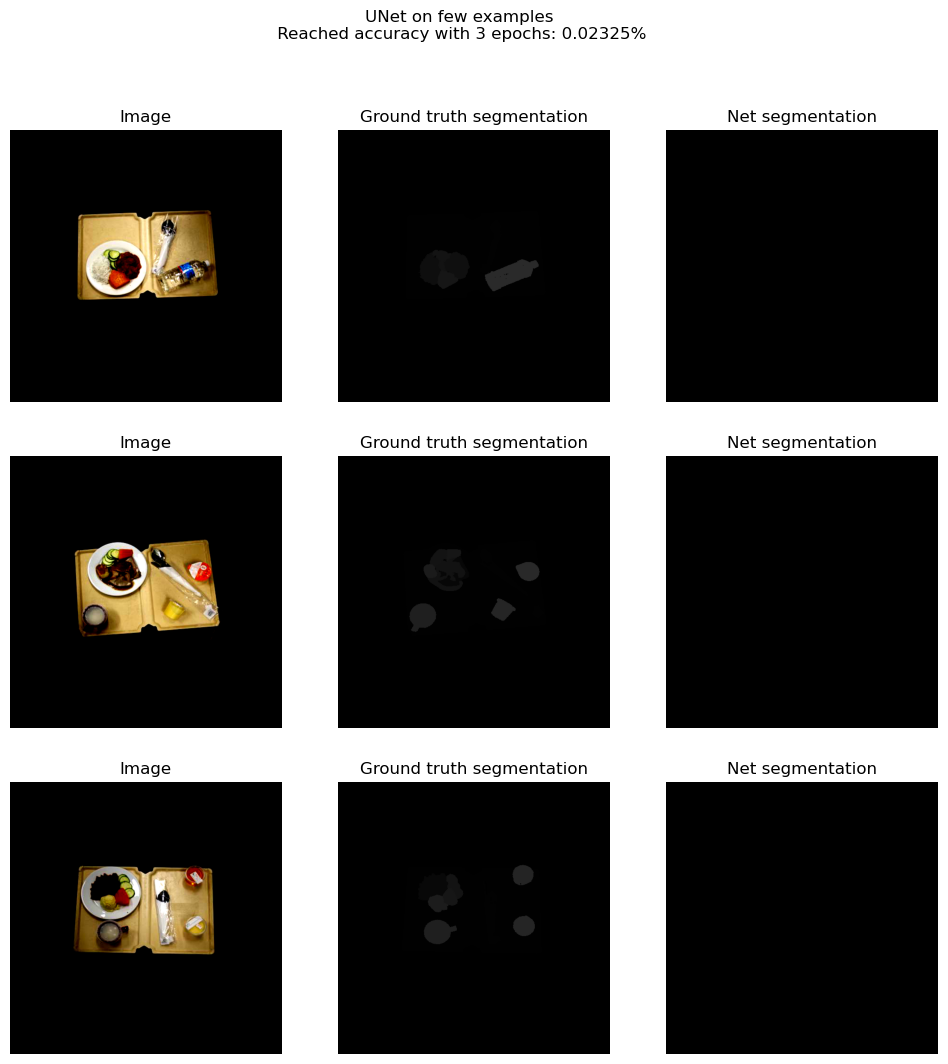

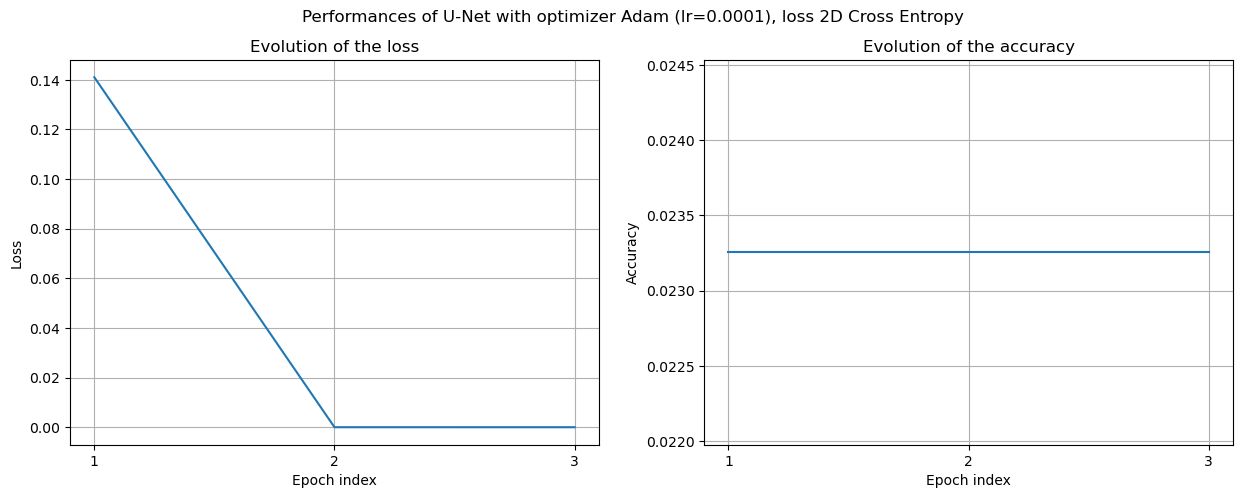

In [149]:
model = trainer.model.to('cuda:0')
plot_results(model, test_dataloader)

file_path      = "results.pkl"
model_name     = "U-Net"
optimizer_name = "Adam"
loss_name      = "2D Cross Entropy"
learning_rate  = 1e-4
save           = True
plot_model_performances(file_path, 
                        model_name, optimizer_name, loss_name, 
                        learning_rate, 
                        save=True)

## Conclusion

As we can see, our model assigns the background class to all pixels after only one epoch. This is due to the 2D cross entropy cost function which isn't adapted to a dataset where the classes are unbalanced. We'll try the Focal Cross Entropy Loss.